<a href="https://colab.research.google.com/github/drwatson93/M2-A3/blob/main/M2_A3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This assignment is to practice SVM classification, PCA dimensionality reduction, and multi-classtext classification.The goal is to select and train a classificationmodel for “Consumer Complaint Database”. You can download the CSVfile from this link: https://catalog.data.gov/dataset/consumer-complaint-database

1. Load data and remove all the rows before year “2021” (filter based on “Datereceived”). This dataset is huge,so we keep only year 2021 to make it a reasonablesize for this assignment.

2. Also drop any row thathas the following products(compositeproducts)

*   a.'Credit reporting, credit repair services, or other personal consumer reports'
* b.'Credit card or prepaid card'
* c.'Checking or savings account'
* d.'Bank account or service'
* e.'Money transfer, virtual currency, or money service'
* f.'Payday loan, title loan, or personal loan'

3. Remove every columnexcept “Product”and“Consumer complaint narrative”. We want to predict “product”from “Consumer complaint narrative” text.

4. Plot a bar chart to shows the distribution of samples by product. Isthe dataset balanced?

5. The main issue for this job is how to encode text to a vector of numbers. We will discus different encoding methodsin module 4 of this program, butfor now we will use “TD-IDF”method. Wewill use the encoder from “sklearn”blindly. If you are interested to learn more, you can read this article: https://medium.com/analytics-vidhya/tf-idf-term-frequency-technique-easiest-explanation-for-text-classification-in-nlp-with-code-8ca3912e58c3

6. Use “TfidfVectorizer”from “sklearn.feature_extraction.text”to extract “td-idf”vectorfor “Consumer complaint narrative”. Use the following parameters:

*   a.stop_words='english'
*   b.sublinear_tf=True
* c.ngram_range=(1, 2)

7. Use the“td-idf”vector as input features to your model(note how bigthe vector is). For the output,use product classes.

8. Our goal is to train SVM classification models. Given the very high number of inputfeatures, it can be very slow (you can try to see it for yourself). Let’s use PCA to reduce the numberof dimensions significantly. Find the number of principal components to preserveminimum 90% variability in data. It may take a few minutes forPCA to run. If your computerhad memory issue, you coulduse IncrementalPCA.

9. Try to find the best SVC model (using cross-validation). Try to find the best combination of the following hyperparameters. Don’t useGridSearchas it can be slow. Use your own logic to find the best combination by selecting some candidates smartly.Even though the dataset is not balanced, but you can still use “accuracy”for cross-validation(you can’t use “roc_auc”for multi-class).

*   C
*   Kernel
* Gamma

10. Report the accuracy of cross validationand compareit toaccuracy on training data. Do you see any sign of “underfitting”or “overfitting”?

11. Print and plot confusionmatrix for theselectedmodel. Analyzethe result.



In [78]:
import pandas as pd
import numpy as np
import re
import sklearn

# to make this notebook's output stable across runs
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

In [38]:
#1. Load data and remove all the rows before year “2021” (filter based on “Datereceived”). This dataset is huge,so we keep only year 2021 to make it a reasonablesize for this assignment.
db_link = "https://files.consumerfinance.gov/ccdb/complaints.csv.zip"
complaint_df = pd.read_csv(db_link)

In [39]:
complaint_df['Date received'] = pd.to_datetime(complaint_df['Date received'])
is_2021 = complaint_df['Date received'].dt.year == 2021
complaint_df_2021 = complaint_df[is_2021]
complaint_df_2021.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
9,2021-03-26,"Credit reporting, credit repair services, or o...",Credit reporting,Unable to get your credit report or credit score,Other problem getting your report or credit score,NaN,NaN,Experian Information Solutions Inc.,GA,303XX,NaN,NaN,Web,2021-03-26,In progress,Yes,NaN,4250366
15,2021-03-23,"Money transfer, virtual currency, or money ser...",Foreign currency exchange,Fraud or scam,NaN,NaN,NaN,Square Inc.,CA,91387,NaN,NaN,Web,2021-03-23,Closed with explanation,Yes,NaN,4239229
30,2021-04-05,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Personal information incorrect,NaN,NaN,National Consumer Telecom & Utilities Exchange...,FL,32818,NaN,NaN,Web,2021-04-05,Closed with explanation,Yes,NaN,4270994
38,2021-04-05,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",GA,310XX,NaN,NaN,Web,2021-04-05,In progress,Yes,NaN,4272430
39,2021-04-05,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",LA,70737,NaN,NaN,Web,2021-04-05,In progress,Yes,NaN,4272421


In [40]:
#2. Also drop any row thathas the following products(compositeproducts)
complaint_df_2021['Product'].unique()

array(['Credit reporting, credit repair services, or other personal consumer reports',
       'Money transfer, virtual currency, or money service',
       'Credit card or prepaid card', 'Debt collection', 'Mortgage',
       'Vehicle loan or lease', 'Checking or savings account',
       'Payday loan, title loan, or personal loan', 'Student loan'],
      dtype=object)

In [41]:
product_to_drop = ['Credit reporting, credit repair services, or other personal consumer reports',
                   'Credit card or prepaid card', 
                   'Checking or savings account', 
                   'Bank account or service', 
                   'Money transfer, virtual currency, or money service', 
                   'Payday loan, title loan, or personal loan']
complaint_df_2021_filtered = complaint_df_2021[~complaint_df_2021['Product'].isin(product_to_drop)]
complaint_df_2021_filtered['Product'].unique()

array(['Debt collection', 'Mortgage', 'Vehicle loan or lease',
       'Student loan'], dtype=object)

In [42]:
#3.Remove every columnexcept “Product”and“Consumer complaint narrative”. We want to predict “product”from “Consumer complaint narrative” text.
complaint_df_2021_filtered_final = complaint_df_2021_filtered[['Product','Consumer complaint narrative']]
complaint_df_2021_filtered_final["Product"].value_counts()

Debt collection          16939
Mortgage                  7169
Vehicle loan or lease     1905
Student loan              1056
Name: Product, dtype: int64

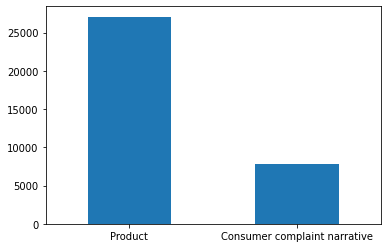

In [43]:
# 4. Plot a bar chart to shows the distribution of samples by product. Isthe dataset balanced? 
complaint_df_2021_filtered_final.count().plot.bar(rot=0)

In [59]:
complaint_df_2021_filtered_final.replace(r'^\s+$', np.nan, regex=True)
complaint_df_2021_filtered_final['Consumer complaint narrative'].fillna('No Comment', inplace=True)
complaint_df_2021_filtered_final['Consumer complaint narrative']

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


89        No Comment
96        No Comment
389       No Comment
407       No Comment
832       No Comment
             ...    
807026    No Comment
807038    No Comment
807056    No Comment
807061    No Comment
807067    No Comment
Name: Consumer complaint narrative, Length: 27069, dtype: object

In [73]:
vectorizer = TfidfVectorizer(stop_words='english', sublinear_tf=True, ngram_range=(1,2))
X_complaint = vectorizer.fit_transform(complaint_df_2021_filtered_final['Consumer complaint narrative'])
#print(vectorizer.get_feature_names())
print(X_complaint.shape)

(27069, 322861)


In [80]:
pca = PCA(n_components = 2, random_state=RANDOM_STATE)
X2D = pca.fit_transform(X_complaint)

TypeError: ignored